In [1]:
from os import listdir
import glob
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from pmdarima import auto_arima
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
def get_actual_data(f, resamp = "MS"):
    filepaths = glob.glob("../data/tidy/" + f + "/*_events_*.csv")
    df = pd.concat(map(pd.read_csv, filepaths), sort=False)
    df["CLINICAL_EVENT_DATETIME"] = pd.to_datetime(df["CLINICAL_EVENT_DATETIME"])
    df.index = df["CLINICAL_EVENT_DATETIME"]
    df_monthly = df.resample(resamp).count()[["EVENT_ID"]]
    df_monthly.columns = ["Actual"]

    # remove current month
    df_monthly = df_monthly[df_monthly.index < datetime.now().strftime('%Y-%m-01')]
    return df_monthly

def arima_model(df, start_p=2, start_q=2, max_p=5, max_q=5):
    auto_mod = auto_arima(df["Actual"], 
                          start_p=start_p,
                          start_q=start_q,
                          max_p=max_p,
                          max_q=max_q,
                          seasonal=False, 
                          stepwise=False)
#                           suppress_warnings=True, 
#                           error_action="ignore")
#     auto_mod.summary()
#     model_arima = ARIMA(df["Actual"], order=auto_mod.order)
#     fit_arima = model_arima.fit()
    return auto_mod

def make_preds_df(fit, df, n=12, freq="MS"):
    fc, se, conf = fit.forecast(n, alpha=0.05)  # 95% conf
    idx = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n, freq=freq)
    fc_series = pd.Series(fc, index=idx)
    lower_series = pd.Series(conf[:, 0], index=idx)
    upper_series = pd.Series(conf[:, 1], index=idx)
    
    df_comb = pd.concat([fc_series.round(0), lower_series.round(0), upper_series.round(0)], axis=1)
    df_comb.index.name = "CLINICAL_EVENT_DATETIME"
    df_comb.columns = ["Forecast", "Lower", "Upper"]
    return df_comb

In [3]:
df_monthly = get_actual_data("ivig")
# df_daily = get_actual_data("acetaminophen", "D")

In [33]:
am = arima_model(df_monthly, 0, 0)
am.summary()

/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 1, 4); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 1, 5); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 1, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   35
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -141.104
Method:                       css-mle   S.D. of innovations             13.048
Date:                Wed, 10 Jul 2019   AIC                            290.207
Time:                        19:29:32   BIC                            296.429
Sample:                             1   HQIC                           292.355
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3716      0.303     -4.532      0.000      -1.965      -0.778
ma.L1.D.y     -0.5155      0.247     -2.089      0.045      -0.999      -0.032
ma.L2.D.y     -0.4845      0.172     -2.817      0.008      -0.822      -0.147
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -2.0641           +0.0000j            2.0641            0.5000
-----------------------------------------------------------------------------
"""

In [5]:
model_arima = ARIMA(df_monthly["Actual"], order=am.order)
fit_arima = model_arima.fit()
fcast = make_preds_df(fit_arima, df_monthly, 12, "MS")

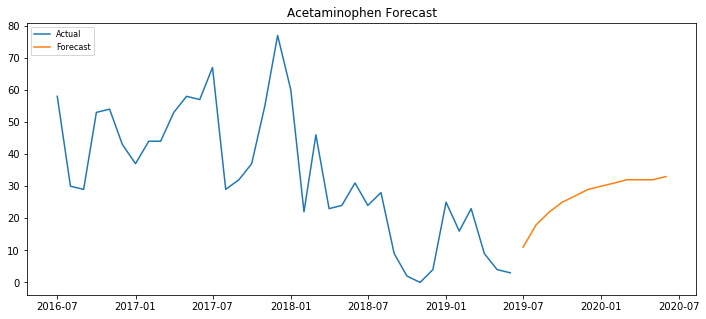

In [42]:
plt.figure(figsize=(12, 5))
plt.plot(df_monthly, label='Actual')
plt.plot(fcast["Forecast"], label='Forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Acetaminophen Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [7]:
# fcast

In [8]:
model_arima = ARIMA(df_monthly["Actual"], order=(1, 0, 0))
fit_arima = model_arima.fit()
fcast = make_preds_df(fit_arima, df_monthly, 12, "MS")

In [9]:
# plt.figure(figsize=(12, 5))
# plt.plot(df_monthly, label='Actual')
# plt.plot(fcast["Forecast"], label='Forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
# plt.title('Acetaminophen Forecast')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

In [10]:
fcast

,Forecast,Lower,Upper
CLINICAL_EVENT_DATETIME,,,
2019-07-01,11.0,-17.0,40.0
2019-08-01,18.0,-17.0,52.0
2019-09-01,22.0,-16.0,59.0
2019-10-01,25.0,-14.0,64.0
2019-11-01,27.0,-12.0,67.0
2019-12-01,29.0,-11.0,69.0
2020-01-01,30.0,-10.0,70.0
2020-02-01,31.0,-9.0,71.0
2020-03-01,32.0,-9.0,72.0


In [11]:
from scipy import stats
from sklearn.preprocessing import PowerTransformer

In [12]:
# lmbda = 1.071479
# xt = stats.boxcox(df_monthly["Actual"], lmbda=lmbda)
# print("lambda = {:g}".format(lam))

# am_xt = auto_arima(xt, start_p=0, start_q=0, seasonal=False, stepwise=False, suppress_warnings=True, error_action="ignore")
# am_xt.summary()
# mod_xt = ARIMA(xt, order=am_xt.order)
# fit_xt = mod_xt.fit()

# fc, se, conf = fit_xt.forecast(12, alpha=0.05)  # 95% conf
# idx = pd.date_range(df_monthly.index[-1] + pd.DateOffset(months=1), periods = 12, freq="MS")
# fc_series = pd.Series(fc, index=idx)
# lower_series = pd.Series(conf[:, 0], index=idx)
# upper_series = pd.Series(conf[:, 1], index=idx)

In [15]:
pt = PowerTransformer()
tf = pt.fit_transform(df_monthly)
print(pt.lambdas_)
# tf = pt.transform(df_monthly)

[0.72009295]


In [34]:
df_tf = pd.DataFrame(tf, columns=["Actual"])
df_tf.index = df_monthly.index
am2 = arima_model(df_tf, 0, 0)

/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 1, 4); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 1, 5); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 1, 1); data is likely non-stationary. (if y

In [35]:
am2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   35
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 -32.325
Method:                       css-mle   S.D. of innovations              0.600
Date:                Wed, 10 Jul 2019   AIC                             76.650
Time:                        19:30:34   BIC                             85.982
Sample:                             1   HQIC                            79.872
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0642      0.045     -1.428      0.164      -0.152       0.024
ar.L1.D.y     -0.3137      0.152     -2.058      0.048      -0.612      -0.015
ar.L2.D.y     -0.2791      0.154     -1.809      0.081      -0.581       0.023
ar.L3.D.y     -0.3353      0.155     -2.159      0.039      -0.640      -0.031
ar.L4.D.y     -0.4387      0.153     -2.872      0.007      -0.738      -0.139
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6062           -1.0048j            1.1735           -0.1636
AR.2            0.6062           +1.0048j            1.1735            0.1636
AR.3           -0.9883           -0.8238j            1.2866           -0.3894
AR.4           -0.9883           +0.8238j            1.2866            0.3894
-----------------------------------------------------------------------------
"""

In [36]:
model_arima = ARIMA(df_tf["Actual"], order=am2.order)
fit_arima = model_arima.fit()
# fcast = make_preds_df(fit_arima, df_tf, 12, "MS")

fc, se, conf = fit_arima.forecast(12, alpha=0.05)  # 95% conf
idx = pd.date_range(df_monthly.index[-1] + pd.DateOffset(months=1), periods = 12, freq="MS")
# fc_series = pd.Series(fc, index=idx)
# lower_series = pd.Series(conf[:, 0], index=idx)
# upper_series = pd.Series(conf[:, 1], index=idx)
    
#     df_comb = pd.concat([fc_series.round(0), lower_series.round(0), upper_series.round(0)], axis=1)
#     df_comb.index.name = "CLINICAL_EVENT_DATETIME"
#     df_comb.columns = ["Forecast", "Lower", "Upper"]


In [37]:
df_fc = pd.DataFrame(fc, index=idx)
fc_tf = pt.inverse_transform(df_fc)

In [38]:
df_fc_tf = pd.DataFrame(fc_tf, columns=["Forecast"])
df_fc_tf.index = idx

In [39]:
# plt.figure(figsize=(12, 5))
# plt.plot(df_monthly, label='Actual')
# plt.plot(df_fc_tf, label='Forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
# plt.title('Acetaminophen Forecast')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

In [40]:
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.functions import SignatureTranslatedFunction
pandas2ri.activate()

In [30]:
forecast = importr('forecast')
forecast.auto_arima = SignatureTranslatedFunction(forecast.auto_arima, init_prm_translate = {'lambda_': 'lambda'})

In [24]:
f = forecast.auto_arima(df_monthly["Actual"], stepwise=False, seasonal=False, lambda_="auto")
fc = forecast.forecast(f, h = 12)

In [25]:
forecast.summary_forecast(fc)


Forecast method: ARIMA(0,1,0)

Model Information:
Series: c("2016-07-01 00:00:00" = 58L, "2016-08-01 00:00:00" = 30L, "2016-09-01 00:00:00" = 29L,  "2016-10-01 00:00:00" = 53L, "2016-11-01 00:00:00" = 54L, "2016-12-01 00:00:00" = 43L,  "2017-01-01 00:00:00" = 37L, "2017-02-01 00:00:00" = 44L, "2017-03-01 00:00:00" = 44L,  "2017-04-01 00:00:00" = 53L, "2017-05-01 00:00:00" = 58L, "2017-06-01 00:00:00" = 57L,  "2017-07-01 00:00:00" = 67L, "2017-08-01 00:00:00" = 29L, "2017-09-01 00:00:00" = 32L,  "2017-10-01 00:00:00" = 37L, "2017-11-01 00:00:00" = 55L, "2017-12-01 00:00:00" = 77L,  "2018-01-01 00:00:00" = 60L, "2018-02-01 00:00:00" = 22L, "2018-03-01 00:00:00" = 46L,  "2018-04-01 00:00:00" = 23L, "2018-05-01 00:00:00" = 24L, "2018-06-01 00:00:00" = 31L,  "2018-07-01 00:00:00" = 24L, "2018-08-01 00:00:00" = 28L, "2018-09-01 00:00:00" = 9L,  "2018-10-01 00:00:00" = 2L, "2018-11-01 00:00:00" = 0L, "2018-12-01 00:00:00" = 4L,  "2019-01-01 00:00:00" = 25L, "2019-02-01 00:00:00" = 16L, "2019

,Point Forecast,Lo 80,Hi 80,Lo 95,Hi 95
37,3.0,0.210226,11.429976,0.001241,19.086557
38,3.0,0.010498,17.204528,-0.131844,31.814748
39,3.0,-0.001303,22.710629,-0.807247,44.570912
40,3.0,-0.047573,28.141033,-2.076708,57.557566
41,3.0,-0.188945,33.561726,-3.898533,70.823008
42,3.0,-0.439093,39.002334,-6.227106,84.377427
43,3.0,-0.800198,44.478019,-9.022468,98.218455
44,3.0,-1.270492,49.997093,-12.250764,112.339164
45,3.0,-1.846760,55.564255,-15.883310,126.731054
46,3.0,-2.525323,61.182151,-19.895597,141.385275


In [26]:
fcst = fc.rx2("mean")

In [27]:
fc_series = pd.DataFrame(fcst, columns=["Forecast"], index=idx)

In [1]:
fc_series

NameError: name 'fc_series' is not defined

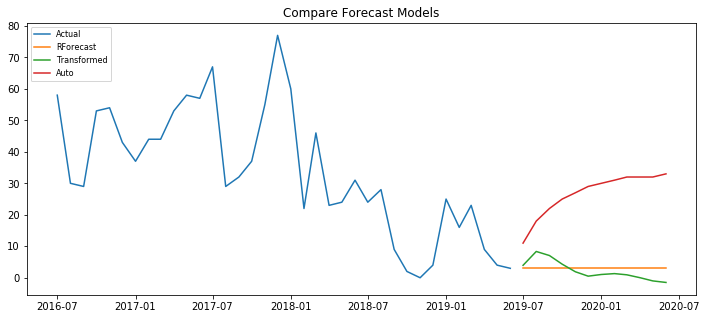

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(df_monthly, label='Actual')
plt.plot(fc_series, label='RForecast')
plt.plot(df_fc_tf, label='Transformed')
plt.plot(fcast["Forecast"], label='Auto')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Compare Forecast Models')
plt.legend(loc='upper left', fontsize=8)
plt.show()